In [30]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

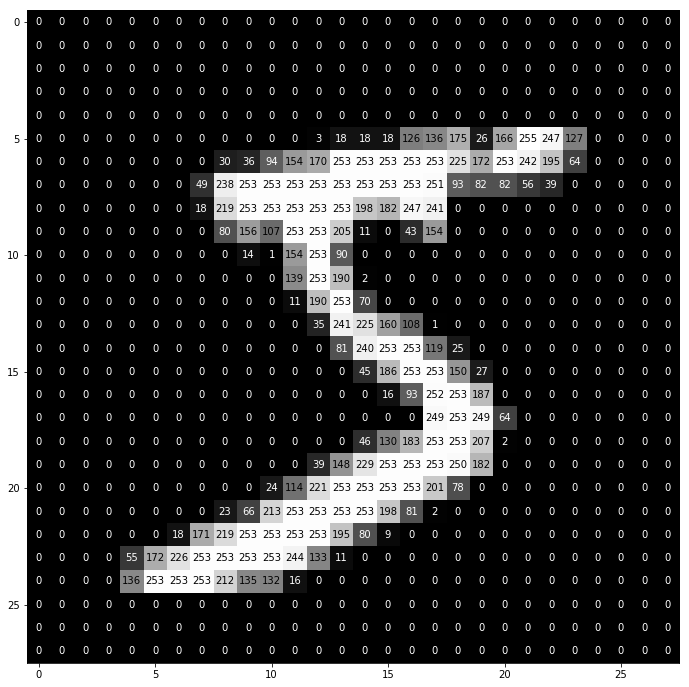

In [2]:
%matplotlib inline
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(X_train[0], ax)

In [35]:
# Preprocessing

#x_train = x_train.reshape(60000, 784)
#x_test = x_test.reshape(10000, 784)
x_train = X_train.astype('float32')/255
x_test = X_test.astype('float32')/255

y_train = np_utils.to_categorical(Y_train, 10)
# Apply label smoothing on training labels
y_train = [lst * 0.9 for lst in y_train]
y_test = np_utils.to_categorical(Y_test, 10)
print("Label encoding before:", Y_train[:3])
print("Label encoding after:\n", y_train[:3])

Label encoding before: [5 0 4]
Label encoding after:
 [array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0.9,  0. ,  0. ,  0. ,  0. ]), array([ 0.9,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]), array([ 0. ,  0. ,  0. ,  0. ,  0.9,  0. ,  0. ,  0. ,  0. ,  0. ])]


In [36]:
def make_trainable(network, val):
    network.trainable = val
    for l in network.layers:
        l.trainable = val

In [43]:
def classifier():
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    hidden = Flatten()(inputs)
    hidden = Dense(512, activation='relu')(hidden)
    hidden = Dropout(0.2)(hidden)
    hidden = Dense(512, activation='relu')(hidden)
    hidden = Dropout(0.2)(hidden)
    output = Dense(10)(hidden)
    activation = Activation(activation='softmax')(output)
    
    C = Model(inputs=inputs, outputs=activation)
    C.compile(loss='categorical_crossentropy', optimizer='adam')
    C.summary()
    return C

def generator(verbose=True):
    inputs = Input(shape=z_dim)
    hidden = Flatten()(inputs)
    hidden = Dense(128, activation=LeakyReLU(alpha=0.01))(hidden)
    logits = Dense(784)(hidden)
    output = Activation('sigmoid')(logits)  # Values between 0 and 1
    
    generator = Model(inputs, output)
    
    optimizer = Adam(lr=0.0001)
    generator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    if verbose: generator.summary()

    return generator

def discriminator(verbose=True):
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    hidden = Flatten()(inputs)
    hidden = Dense(128, activation=LeakyReLU(alpha=0.01))(hidden)
    logits = Dense(2)(hidden)
    output = Activation('sigmoid')(logits) # Values between 0 and 1

    discriminator = Model(inputs, output)
    
    optimizer = Adam(lr=0.002)
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    if verbose: discriminator.summary()
        
    return discriminator

def GAN(g, d, verbose=True):
    """
    - First, set the discriminator to untrainable. We don't want it to learn
    when training the stacked model of G and D.
    - Then, stack both models
    """
    inputs = Input(shape=z_dim)
    hidden = g(inputs)
    output = d(hidden)
    
    GAN = Model(inputs, output)
    
    optimizer = RMSprop(lr=0.002)
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    if verbose: GAN.summary()
        
    return GAN
    

In [44]:
def plot_loss(losses, metric=0):
    """
    @param metric:
        0: loss
        1: accuracy
    """
    if metric:
        label='accuracy'
    else:
        label='loss'
    
    Ddata = [v[metric] for v in losses["D"]]
    Gdata = [v[metric] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(Ddata, label="Discriminator "+label)
    plt.plot(Gdata, label="Generator "+label)
    plt.legend()
    plt.show()
    
def plot_generated(g, n_ex=6, dim=(1, 6), figsize=(10, 7)):
    noise=np.random.uniform(0, 1, size=(n_ex, z_dim[0], z_dim[1]))
    generated_images = g.predict(noise)
    generated_images = np.reshape(generated_images, (generated_images.shape[0], X_train.shape[1], X_train.shape[2]))
    print(generated_images.shape)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        img = generated_images[i, :, :]
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    #plt.tight_layout()
    plt.show()

In [45]:
# Set the dimensions of the noise
z_dim = (10, 10)

In [46]:
# Creat the models
g = generator()
d = discriminator()
make_trainable(d, False)
gan = GAN(g, d)

# Pre-train the discriminator on a random sample of train input

# Gather a sample of the real images
n_train = 10000
train_indices = random.sample(range(0, X_train.shape[0]), n_train)
X_pretrain = X_train[train_indices, :, :]
print("Shape of X_pretrain:", X_pretrain.shape)

# Gather a sample of fake images (equal in size as real images)
noise_gen = np.random.uniform(0, 1, size=(X_pretrain.shape[0], z_dim[0], z_dim[1]))
print("Shape of noise_gen:", noise_gen.shape)
generated_images = g.predict(noise_gen)
generated_images = np.reshape(generated_images, (generated_images.shape[0], X_train.shape[1], X_train.shape[2]))
print("Shape of generated_images", generated_images.shape)

# Add both samples together
X = np.concatenate((X_pretrain, generated_images))

# Create the labels
n = X_pretrain.shape[0]  # Number of samples
y = np.zeros([2 * X_pretrain.shape[0], 2])  # one-hot encoded matrix of labels
y[:n, 1] = 1  # first half are real images, so set the 1-value to 1
y[n:, 0] = 1  # 2nd half are fake images, so set the 0-value to 1

make_trainable(d, True)
d.fit(X, y, epochs=1, batch_size=128)

y_hat = d.predict(X)
y_hat_index = np.argmax(y_hat, axis=1)  # index of predicted label
y_index = np.argmax(y, axis=1)  # index of true label
diff = y_index - y_hat_index
n_tot = y.shape[0]
n_correct = (diff==0).sum()
acc = 100.0 * n_correct / n_tot
print("Accuracy: %0.02f pct. (%d of %d correctly predicted)" % (acc, n_correct, n_tot))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 10, 10)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_22 (Dense)             (None, 784)               101136    
_________________________________________________________________
activation_11 (Activation)   (None, 784)               0         
Total params: 114,064.0
Trainable params: 114,064.0
Non-trainable params: 0.0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #  

In [47]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}

def train(g, d, gan, epochs=1000, plt_frq=200, BATCH_SIZE=100):
    for e in tqdm(range(epochs)):
        # Create a batch by drawing random index numbers from the training set
        image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE), :, :]

        # Generate images
            # Prepare noise images for the batch
        noise_gen = np.random.uniform(0, 1, size=(BATCH_SIZE, z_dim[0], z_dim[1]))
            # Generate the images from the noise
        generated_images = g.predict(noise_gen)
        generated_images = np.reshape(generated_images, (generated_images.shape[0], X_train.shape[1], X_train.shape[2]))
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2 * BATCH_SIZE, 2])
        y[0:BATCH_SIZE, 1] = 1
        y[BATCH_SIZE:, 0] = 1
        
        #make_trainable(d, True)
        d_loss = d.train_on_batch(X, y)
        losses["D"].append(d_loss)
        
        # Train GAN stack - input = noise, output = train for label 1 (we want the D to think it's a real image)
        noise_tr = np.random.uniform(0, 1, size=(BATCH_SIZE, z_dim[0], z_dim[1]))
        y2 = np.zeros([BATCH_SIZE, 2])
        y2[:, 1] = 1
        
        #make_trainable(d, False)
        g_loss = gan.train_on_batch(noise_tr, y2)
        losses["G"].append(g_loss)
        
        # Update the plots
        if e%plt_frq == plt_frq - 1:
            #plot_loss(losses)
            print("Losses at epoch",e)
            print("D_loss:", d_loss,"  ---  G_loss:",g_loss)
            plot_generated(g)
    plot_loss(losses, metric=0)

100%|█████████████████████████████████████████████████████████████████████████████▊| 998/1000 [00:08<00:00, 116.20it/s]

Losses at epoch 999
D_loss: [0.032747455, 0.99999994]   ---  G_loss: [2.8890634, 0.0]
(6, 28, 28)


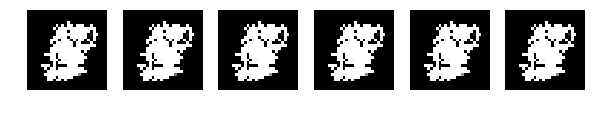

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.45it/s]


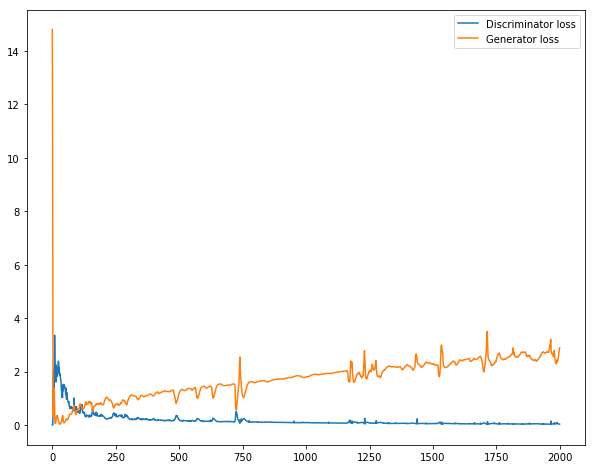

In [49]:
train(g, d, gan, epochs=1000, plt_frq=1000)